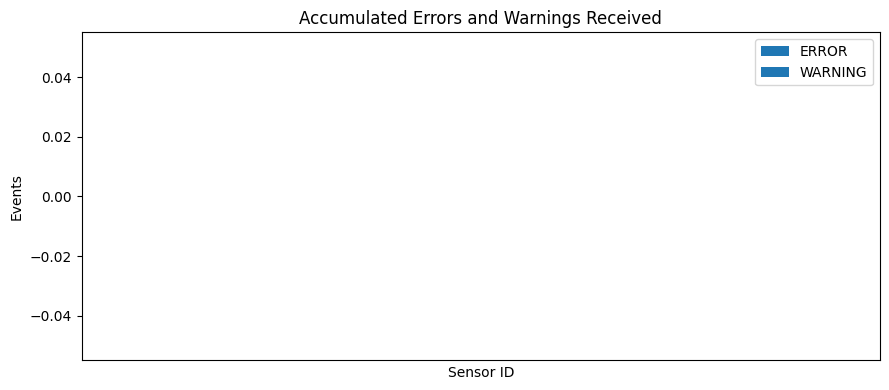

Stopped by user


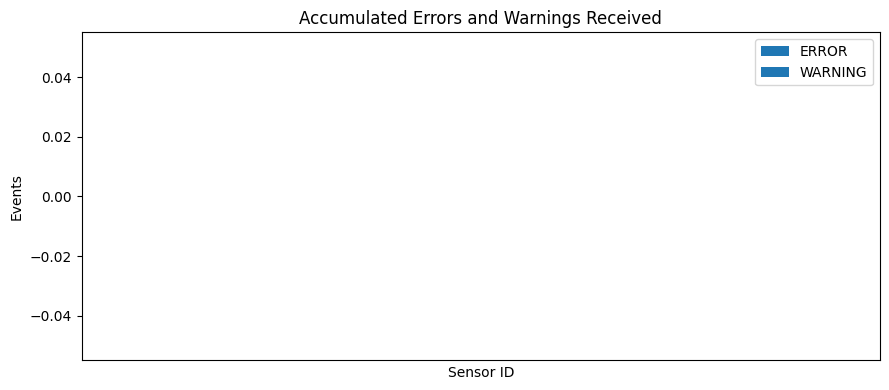

In [ ]:
"""
sensor_logs_dashboard

Real-time dashboard to visualize Kafka sensor log events (ERRORs and WARNINGs).
Reads from the 'log-data' Kafka topic and displays an updating bar chart of
accumulated counts per sensor in a Jupyter notebook environment.
"""

from IPython.display import clear_output, display
import json
import time
from collections import Counter
import matplotlib.pyplot as plt
from confluent_kafka import Consumer

# --- Kafka configuration ---
# Define connection parameters and subscribe to the log-data topic
conf = {
    "bootstrap.servers": "localhost:9092",  # Kafka broker address(es)
    "group.id": "log-vis-group",             # Consumer group identifier
    "auto.offset.reset": "latest",           # Start from latest messages
}
consumer = Consumer(conf)
consumer.subscribe(["log-data"])

# --- In-memory counters ---
# Track number of ERROR and WARNING messages per sensor
error_counts = Counter()    # sensor_id -> error count
warning_counts = Counter()  # sensor_id -> warning count

# --- Plot setup ---
# Create the matplotlib Figure and Axes once, to update live
fig, ax = plt.subplots(figsize=(9, 4))

def update_plot():
    """
    Redraw the bar chart to reflect current error and warning counts.

    Clears existing axes, computes sorted sensor IDs, and plots stacked
    bars: red for ERROR counts and orange for WARNING counts. Annotates
    each segment with its numeric value and configures layout and labels.
    """
    ax.clear()

    # Combine sensor IDs from both error and warning counters
    sensor_ids = sorted(set(error_counts) | set(warning_counts))
    errs  = [error_counts[s]   for s in sensor_ids]
    warns = [warning_counts[s] for s in sensor_ids]

    # Plot stacked bars: errors at bottom, warnings stacked above
    bars_err = ax.bar(sensor_ids, errs, label="ERROR",   color="tab:red")
    bars_wrn = ax.bar(sensor_ids, warns, bottom=errs, label="WARNING", color="tab:orange")

    # Configure axes ticks and limits
    ax.set_xticks(sensor_ids)
    ax.set_xlim(min(sensor_ids) - 0.5, max(sensor_ids) + 0.5)

    # Axis labels and title
    ax.set_xlabel("Sensor ID")
    ax.set_ylabel("Event Count")
    ax.set_title("Accumulated Errors and Warnings by Sensor")
    ax.legend()

    # Annotate each bar segment with its count
    for err_bar, wrn_bar, e, w in zip(bars_err, bars_wrn, errs, warns):
        # Draw error count label centered in red segment
        ax.annotate(
            f"{e}",
            xy=(err_bar.get_x() + err_bar.get_width() / 2, e / 2),
            ha="center", va="center", color="white", fontweight="bold"
        )
        # Draw warning count label centered in orange segment
        ax.annotate(
            f"{w}",
            xy=(wrn_bar.get_x() + wrn_bar.get_width() / 2, e + w / 2),
            ha="center", va="center", color="white", fontweight="bold"
        )

    plt.tight_layout()

# --- Main loop: consume and update ---
try:
    last_redraw = time.time()  # timestamp of last plot refresh

    while True:
        # Poll Kafka for new messages, timeout after 200ms
        msg = consumer.poll(0.2)
        if msg and msg.value():
            # Parse message JSON and extract sensor_id and log level
            entry = json.loads(msg.value())
            sid = entry.get("sensor_id")
            level = entry.get("level")

            # Increment corresponding counter
            if level == "ERROR":
                error_counts[sid] += 1
            elif level == "WARNING":
                warning_counts[sid] += 1

        # Redraw the chart at 1-second intervals
        if time.time() - last_redraw >= 1.0:
            clear_output(wait=True)  # clear previous cell output
            update_plot()            # redraw with updated counts
            display(fig)             # show in notebook
            last_redraw = time.time()  # update timestamp

except KeyboardInterrupt:
    # Handle user interrupt (e.g., Ctrl+C) to stop consumption
    print("Stopped by user")

finally:
    # Ensure consumer is properly closed on exit
    consumer.close()
